## Imports

In [82]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
import zipfile
import tarfile

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy

from sklearn.neighbors import KDTree
from scipy.spatial import Voronoi
from scipy.spatial import Delaunay
from scipy.interpolate import RBFInterpolator

from components.fov_conv2d_cont import FovConv2dCont

sys.path.append('../data/EGTEA/Gaze_Data/gaze_data') 
from gaze_io_sample import parse_gtea_gaze

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GTEA Gaze+ Dataset
EGTEA Gaze+ is by far **the largest and most comprehensive** dataset for First Person Vision (**FPV**), with an emphasis on FPV action recognition and gaze estimation. The dataset comes with first person videos, gaze tracking data, densely annotated action labels and sparsely annotated hand masks. 

In [83]:
# # Define the root directory where all the zips are located
# root_dir = "../data/EGTEA"  # Replace with the path to your EGTEA folder

# # Walk through all subdirectories and extract zip files
# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.endswith(".zip"):
#             zip_path = os.path.join(subdir, file)
#             extract_to = subdir  # Extract to the same directory as the zip file
            
#             print(f"Extracting {zip_path} to {extract_to}...")
#             with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#                 zip_ref.extractall(extract_to)
#             print(f"Finished extracting {file}")

# # Define the root directory where all the tar files are located
# root_dir = "../data/EGTEA"  # Replace with the path to your EGTEA folder

# # Walk through all subdirectories and extract tar files
# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.endswith(".tar"):  # Check for tar files
#             tar_path = os.path.join(subdir, file)
#             extract_to = subdir  # Extract to the same directory as the tar file
            
#             print(f"Extracting {tar_path} to {extract_to}...")
#             with tarfile.open(tar_path, 'r') as tar_ref:
#                 tar_ref.extractall(extract_to)
#             print(f"Finished extracting {file}")

In [84]:
file_name = "OP01-R01-PastaSalad"

# Path to the gaze data file
gaze_data_path = f"../data/EGTEA/Gaze_Data/gaze_data/gaze_data/{file_name}.txt"
gaze_data = parse_gtea_gaze(gaze_data_path)
gaze_data.shape

# Path to the video file
video_path = f"../data/EGTEA/Raw_Videos/{file_name}.mp4"

Frame 50: Gaze Point (0.57, 0.56), Gaze Type: 1


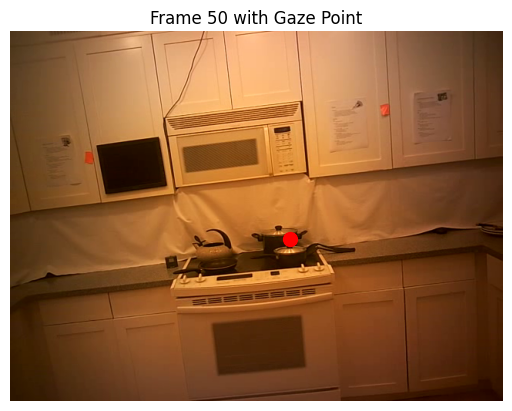

In [85]:
# Index of the frame to analyze
frame_i = 50

# Open the video
cap = cv2.VideoCapture(video_path)

# Get the gaze data for the specific frame
gaze_point = gaze_data[frame_i, :]

if gaze_point[2] == 4:  # Gaze truncated (out of bounds)
    print(f"Frame {frame_i}: Gaze point out of bounds.")
else:
    gaze_x, gaze_y = gaze_point[0], gaze_point[1]  # Normalized coordinates
    gaze_type = int(gaze_point[2])
    print(f"Frame {frame_i}: Gaze Point ({gaze_x:.2f}, {gaze_y:.2f}), Gaze Type: {gaze_type}")

# Set the video to the desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
ret, frame = cap.read()

if ret:
    # Denormalize gaze coordinates to image resolution
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    gaze_x_px = int(gaze_point[0] * frame_width)
    gaze_y_px = int(gaze_point[1] * frame_height)

    # # Overlay the gaze point on the frame
    # cv2.circle(frame, (gaze_x_px, gaze_y_px), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    # Display the frame with Matplotlib
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    # overlay the gaze point
    plt.scatter(gaze_x_px, gaze_y_px, color='red', s=100)
    plt.title(f"Frame {frame_i} with Gaze Point")
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Could not retrieve frame {frame_i}.")

cap.release()

256


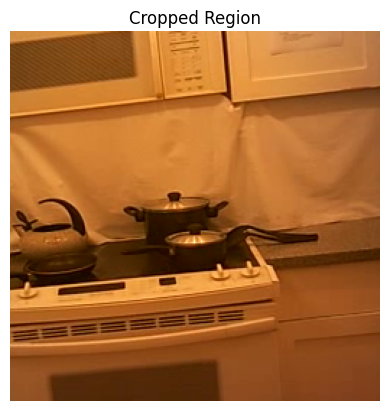

In [86]:
# Function to crop a 256x256 region centered on the gaze point
def crop_frame(frame, gaze_x, gaze_y, crop_size, resize=None):
    h, w, _ = frame.shape  # Height, width of the frame
    x_center = int(gaze_x * w)  # Convert normalized gaze_x to pixel value
    y_center = int(gaze_y * h)  # Convert normalized gaze_y to pixel value

    # Calculate crop boundaries
    x1 = max(0, x_center - crop_size // 2)
    y1 = max(0, y_center - crop_size // 2)
    x2 = min(w, x_center + crop_size // 2)
    y2 = min(h, y_center + crop_size // 2)

    # Crop the region
    cropped_frame = frame[y1:y2, x1:x2]

    # If the crop is smaller than 256x256 (e.g., near the frame edge), pad it
    if cropped_frame.shape[0] != crop_size or cropped_frame.shape[1] != crop_size:
        cropped_frame = cv2.copyMakeBorder(
            cropped_frame,
            top=max(0, crop_size // 2 - y_center),
            bottom=max(0, y_center + crop_size // 2 - h),
            left=max(0, crop_size // 2 - x_center),
            right=max(0, x_center + crop_size // 2 - w),
            borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0)  # Black padding
        )

    # Resize the cropped region to 256x256
    if resize:
        cropped_frame = cv2.resize(cropped_frame, (resize, resize))

    return cropped_frame

# Define the frame resolution and crop size
camera_fov = 40  # Camera field of view in degrees, this is an estimate, i can't find online what the actual fov is
phosphene_fov = 16

ratio = phosphene_fov / camera_fov 
crop_size = int(frame_width * ratio)
print(crop_size)

if ret:
    cropped = crop_frame(frame, gaze_x, gaze_y, crop_size=crop_size, resize=None)

    # Display the cropped region
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Region")
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Could not retrieve frame {frame_i}.")

# Simulator

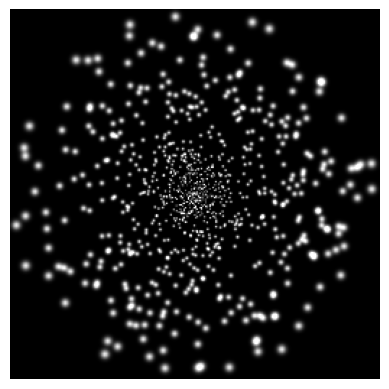

In [87]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')
params['run']['resolution'] = [crop_size, crop_size]

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

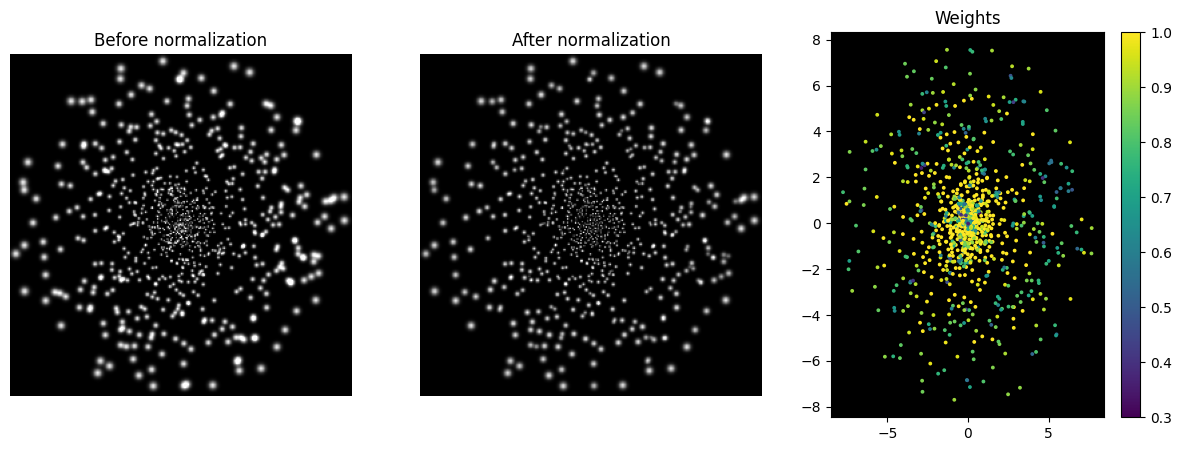

In [88]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=1,
    scale=0.5,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.05,
    steps=50,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init)
stim_weights = normalizer.weights

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# Fov Conv2D LoG Module

In [89]:
from components.adaptive_conv2d import AdaptiveConv2d
from phosphene.density import VisualFieldMapper

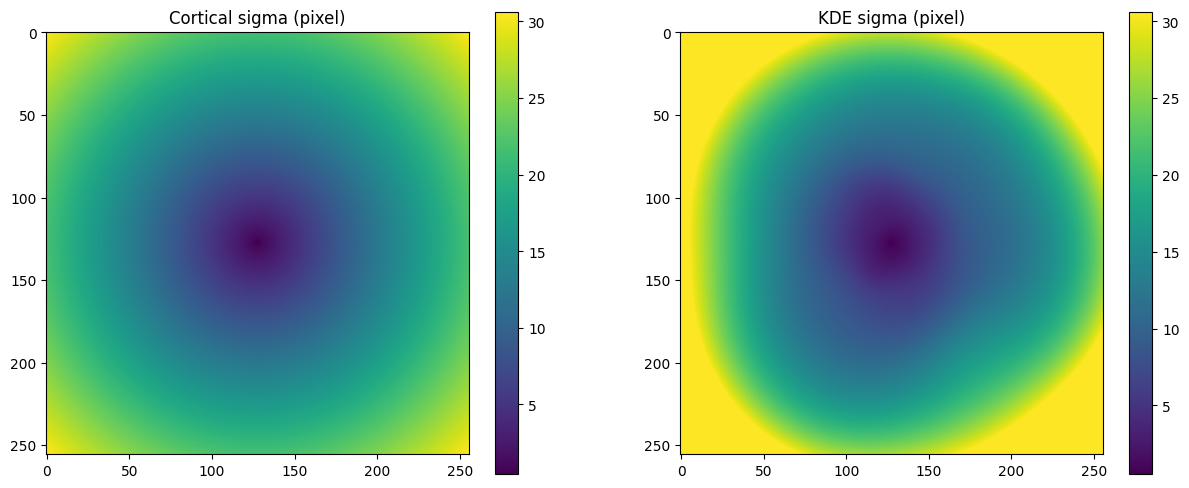

In [90]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=32, alpha=1.0, total_phosphenes=1024)
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

# plot sigma_cortical_pix, sigma_kde_pix

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

In [91]:
sigma_map_tensor = torch.Tensor(sigma_cortical_pix).float().cuda().unsqueeze(0).unsqueeze(0).detach()
in_channels = 1
out_channels = 1
kernel_size = 1
net = AdaptiveConv2d(in_channels, out_channels, kernel_size, kernel_type='LoG', sigma_map=sigma_map_tensor,
                    log_kernel_size=137, sigma_function='map', padding_mode='reflect').cuda()
net.eval()

foa_xy = torch.tensor([128, 128]).float().cuda().unsqueeze(0).detach()

/gpfs/home1/mappel/Dynaphos/spatial_frequency/notebooks/./../components/adaptive_conv2d.py:326: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_map = torch.tensor(sigma_map, dtype=torch.float32)


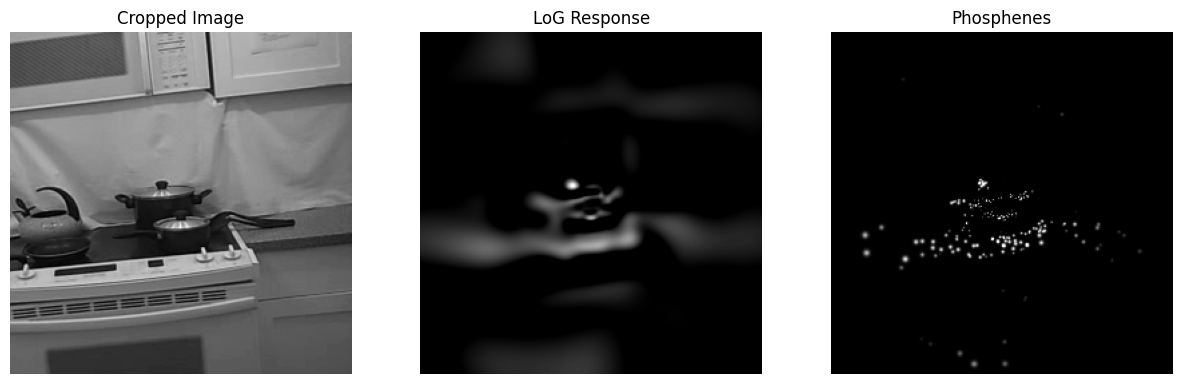

In [92]:
image = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
image_tensor = torch.Tensor(image).float().cuda().unsqueeze(0).unsqueeze(0).detach()

with torch.no_grad():
    response = net(image_tensor, foa_xy).clip(0, None).detach()
response = (response - response.min()) / (response.max() - response.min())
response = response.squeeze().cpu().detach().numpy()

stimulus = torch.tensor(response).float().cuda()
simulator.reset()
phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*np.pi*stim_weights) 

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Cropped Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(response, cmap='gray')
plt.title('LoG Response')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.title('Phosphenes')
plt.axis('off')

plt.show()

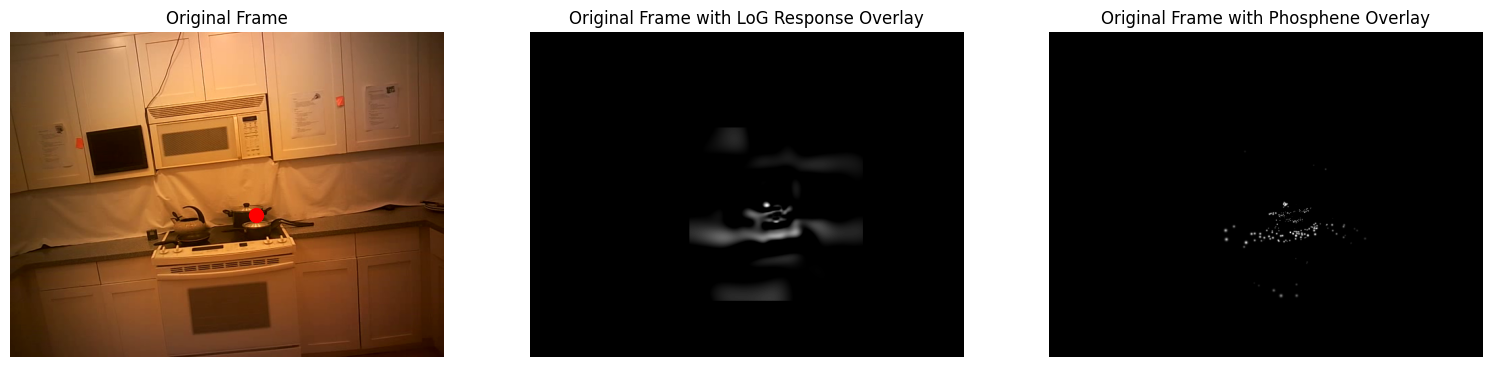

In [93]:
def overlay_phosphene(original_frame, phosphene_image, gaze_x, gaze_y, fov_camera=90, fov_phosphene=16):
    """
    Overlay the phosphene image back into the original frame space.

    Parameters:
        original_frame (numpy array): Original frame (grayscale, e.g., 640x480).
        phosphene_image (numpy array): Phosphene image (grayscale, e.g., 256x256).
        gaze_x (float): Normalized gaze x-coordinate (0 to 1).

    Returns:
        combined_image (numpy array): Image with phosphene overlaid.
    """
    # Ensure the frame is black initially float32
    frame_height, frame_width = original_frame.shape[:2]
    combined_image = np.zeros((frame_height, frame_width), dtype=np.float32)

    # Convert normalized gaze coordinates to pixel positions
    x_center = int(gaze_x * frame_width)
    y_center = int(gaze_y * frame_height)

    # Get phosphene image dimensions
    phos_h, phos_w = phosphene_image.shape
    # # resize the phosphene image proportionally to the fovs
    # phos_w = int(frame_width * (fov_phosphene / fov_camera))
    # phos_h = int(frame_height * (fov_phosphene / fov_camera))

    # # resize the phosphene image to the new size
    # phosphene_image = cv2.resize(phosphene_image, (phos_w, phos_h))

    # Compute the top-left corner of the phosphene placement
    x1 = max(0, x_center - phos_w // 2)
    y1 = max(0, y_center - phos_h // 2)
    x2 = min(frame_width, x_center + phos_w // 2)
    y2 = min(frame_height, y_center + phos_h // 2)

    # Compute the region of the phosphene image to use
    phos_x1 = max(0, phos_w // 2 - x_center)
    phos_y1 = max(0, phos_h // 2 - y_center)
    phos_x2 = phos_x1 + (x2 - x1)
    phos_y2 = phos_y1 + (y2 - y1)

    # Overlay the phosphene onto the combined image
    combined_image[y1:y2, x1:x2] = phosphene_image[phos_y1:phos_y2, phos_x1:phos_x2]

    return combined_image

overlayed_response = overlay_phosphene(
    original_frame=frame,
    phosphene_image=response,
    gaze_x=gaze_x,
    gaze_y=gaze_y,
)

overlayed_phosphenes = overlay_phosphene(
    original_frame=frame,
    phosphene_image=phosphenes.cpu().numpy(),
    gaze_x=gaze_x,
    gaze_y=gaze_y,
)

# Display the result side by side with the original frame
plt.figure(figsize=(19, 12))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# overlay
plt.scatter(gaze_x_px, gaze_y_px, color='red', s=100)
plt.title("Original Frame")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(overlayed_response, cmap="gray")
plt.title("Original Frame with LoG Response Overlay")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlayed_phosphenes, cmap="gray")
plt.title("Original Frame with Phosphene Overlay")
plt.axis("off")
plt.show()

# Smooth Gaze Data for blinks

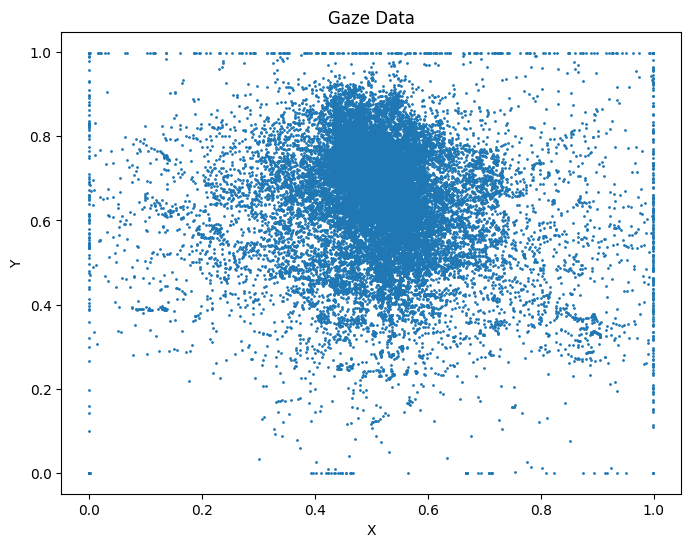

In [94]:
# plot eye gaze data
plt.figure(figsize=(8, 6))
# scatterplot x,y gaze data
plt.scatter(gaze_data[:,0], gaze_data[:,1], s=1)
plt.title('Gaze Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [95]:
blink_epsilon = 0.05
# find blinks where x or y is less than epsilon or more than 1-epsilon
blink_indices = np.where(
    (gaze_data[:,0] < blink_epsilon) | (gaze_data[:,0] > 1-blink_epsilon) |
    (gaze_data[:,1] < blink_epsilon) | (gaze_data[:,1] > 1-blink_epsilon)
)[0]

# n many blnks found
print(len(blink_indices), 'blinks found')

3582 blinks found


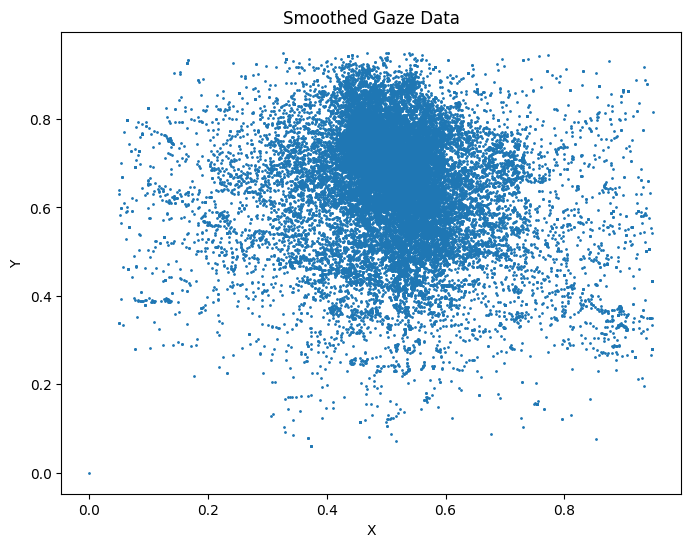

In [96]:
# wherever the blink is, set the gaze point to the last valid gaze point
smnoothed_gaze_data = gaze_data.copy()
for i in blink_indices:
    smnoothed_gaze_data[i] = smnoothed_gaze_data[i-1]

# plot eye gaze data
plt.figure(figsize=(8, 6))
# scatterplot x,y gaze data
plt.scatter(smnoothed_gaze_data[:,0], smnoothed_gaze_data[:,1], s=1)
plt.title('Smoothed Gaze Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


# Video processing

In [97]:
file_name = "OP01-R01-PastaSalad"

# Path to the gaze data file
gaze_data_path = f"../data/EGTEA/Gaze_Data/gaze_data/gaze_data/{file_name}.txt"
gaze_data = parse_gtea_gaze(gaze_data_path)
gaze_data.shape

# Path to the video file
video_path = f"../data/EGTEA/Raw_Videos/{file_name}.mp4"

out_path = f"../out/{file_name}_phosphene_camFOV{camera_fov}_phosFOV_{phosphene_fov}_corticalmag_demo_4min.mp4"
out_path

'../out/OP01-R01-PastaSalad_phosphene_camFOV40_phosFOV_16_corticalmag_demo_4min.mp4'

In [98]:
framerate = 30
max_n_frames = 4*60*framerate

cap = cv2.VideoCapture(video_path)
# print length of video
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(length, 'frames')

35924 frames


In [99]:
# Define the frame resolution and crop size
camera_fov = 40  # Camera field of view in degrees, this is an estimate, i can't find online what the actual fov is
phosphene_fov = 16
# based on fovs
ratio = phosphene_fov / camera_fov 
crop_size = int(frame_width * ratio)

In [100]:
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

if not cap.isOpened():
    print('Unable to read file :(')

# Set the output stream
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(out_path, fourcc, framerate, (frame_width,3*frame_height), isColor=True)

# Loop over frames
frame_nr = 0
while frame_nr<max_n_frames:
    # load next frame
    ret, frame = cap.read()
    frame_nr+=1
    
    if not ret:
        break 

    # Get the gaze data for the specific frame
    gaze_point = smnoothed_gaze_data[frame_nr, :]
    if gaze_point[2] == 4:  # Gaze truncated (out of bounds)
        print(f"Frame {frame_nr}: Gaze point out of bounds.")
        continue
    else:
        gaze_x, gaze_y = gaze_point[0], gaze_point[1]

    # crop around gaze point    
    cropped = crop_frame(frame, gaze_x, gaze_y, crop_size=crop_size, resize=None)
    # to grayscale
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    cropped_tensor = torch.Tensor(cropped).float().cuda().unsqueeze(0).unsqueeze(0).detach()

    # LoG response
    with torch.no_grad():
        response = net(cropped_tensor, foa_xy).clip(0, None).detach()
    response = (response - response.min()) / (response.max() - response.min())
    response_numpy = response.squeeze().cpu().detach().numpy()

    # overlay LoG response
    overlayed_response = overlay_phosphene(
        original_frame=frame,
        phosphene_image=response_numpy,
        gaze_x=gaze_x,
        gaze_y=gaze_y,
        fov_camera=camera_fov,
        fov_phosphene=phosphene_fov
    )

    simulator.reset()
    phosphenes = simulator(simulator.sample_stimulus(response, rescale=True)*3*stim_weights).detach().cpu()

    # overlay phosphenes
    overlayed_phosphenes = overlay_phosphene(
        original_frame=frame,
        phosphene_image=phosphenes.cpu().numpy(),
        gaze_x=gaze_x,
        gaze_y=gaze_y,
        fov_camera=camera_fov,
        fov_phosphene=phosphene_fov
    )

    # make response_img and phosphenes_img have 3 channels
    response_img = overlayed_response*255
    phosphenes_img = overlayed_phosphenes*255

    # Convert 1-channel grayscale images to 3-channel images
    response_img_3ch = cv2.cvtColor(response_img.astype('uint8'), cv2.COLOR_GRAY2BGR)
    phosphenes_img_3ch = cv2.cvtColor(phosphenes_img.astype('uint8'), cv2.COLOR_GRAY2BGR)

    # add red dot for gaze point over frame
    gaze_x_px = int(gaze_x * frame_width)
    gaze_y_px = int(gaze_y * frame_height)
    cv2.circle(frame, (gaze_x_px, gaze_y_px), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    cat = np.concatenate([frame, response_img_3ch, phosphenes_img_3ch], axis=0).astype('uint8')
    
    out.write(cat)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release() 

cv2.destroyAllWindows()